In [2]:
import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Input, Dense, Activation, GaussianNoise, LeakyReLU, Dropout

In [9]:
feature = pd.read_csv('SVMRFE.csv')

In [10]:
features = feature.iloc[:,1:-1]
target = feature.iloc[:,-1]

In [11]:
# Stop training model when "monitor parameter" has stopped improving
earlyStopping = EarlyStopping(monitor='loss', patience=50) # patience is num of epochs to reach early stopping
# Save model after every epoch
checkpointer = ModelCheckpoint(filepath='SDAE_Training.keras', verbose=1, save_best_only=True)
input_dims = (len(features)-1)

In [12]:
# Define denoising autoencoder function
def dae(inputX, input_dims, output_dims, epoch, activation, loss, opti):
    model = Sequential()

    # Check if input_dims is greater than 9999 to decide on CPU or GPU usage
    if input_dims > 9999:
        with tensorflow.device('/cpu:0'):
            print("Using CPU....")
            model.add(Dense(input_dims, input_dim=input_dims))
            model.add(GaussianNoise(0.5))
            model.add(Dense(output_dims, activation=activation, kernel_regularizer=regularizers.l1(0.01)))
            model.add(Dense(input_dims, activation=activation))
            model.compile(loss=loss, optimizer=opti)
            model.fit(inputX, inputX, epochs=epoch, batch_size=4)
            model.summary()
    else:
        with tensorflow.device('/device:GPU:0'):
            print("Using GPU....")
            model.add(Dense(input_dims, input_dim=input_dims))
            model.add(GaussianNoise(0.5))
            model.add(Dense(output_dims, activation=activation, kernel_regularizer=regularizers.l1(0.01)))
            model.add(Dense(input_dims, activation=activation))
            model.compile(loss=loss, optimizer=opti)
            model.fit(inputX, inputX, epochs=epoch, batch_size=4)
            model.summary()

    return model

In [13]:
# Call DAE function with features
autoencoder = dae(features,
                  input_dims=features.shape[1],  # Assuming all columns are used as input dimensions
                  output_dims=500,
                  epoch=3,
                  activation='relu',
                  loss='mse',
                  opti='adam'
                 )

Using CPU....


c:\Users\ASUS\miniforge3\envs\bio2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
168/168 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - loss: 155.9175
Epoch 2/3
168/168 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - loss: 7.9646
Epoch 3/3
168/168 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - loss: 7.5430


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12000)          │   144,012,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 12000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │     6,000,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12000)          │     6,012,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,073,502 (1.74 GB)

 Trainable params: 156,024,500 (595.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 312,049,002 (1.16 GB)

In [12]:
# Hyper-parameter
layers = [12000, 8000, 4000, 500] # Setting the size of your layer
epoch = 3
optimizer = 'adam'
activation = 'relu'
loss = 'mse'

In [16]:
# SDAE pre-train
def sdae_pretrain (inputX, layers, activation, epoch, optimizer, loss):

    encoder = []
    decoder = []
    ae = []

    for i in range(len(layers)-1):
            print("Now pretraining layer {} [{}-->{}]".format(i+1, layers[i], layers[i+1]))

            input_dims = layers[i]
            output_dims = layers[i+1]

            autoencoder = dae(inputX, input_dims, output_dims, epoch, activation, loss, optimizer)
            enc = Sequential()
            enc.add(Dense(output_dims, input_dim=input_dims))
            enc.compile(loss=loss, optimizer=optimizer)
            enc.layers[0].set_weights(autoencoder.layers[2].get_weights())
            inputX = enc.predict(inputX)
            print("check dimension : ", inputX.shape)
            enc.summary()
            encoder.append(autoencoder.layers[2].get_weights())
            decoder.append(autoencoder.layers[3].get_weights())
            ae.append(autoencoder)

    return ae

In [25]:
X = features
Y = target
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [18]:
Train_SDAE = sdae_pretrain( X, layers = layers, activation = activation, epoch = epoch, optimizer = optimizer, loss = loss)

Now pretraining layer 1 [12000-->8000]
Using CPU....


c:\Users\ASUS\miniforge3\envs\bio2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
168/168 ━━━━━━━━━━━━━━━━━━━━ 567s 3s/step - loss: 1923.2341
Epoch 2/3
168/168 ━━━━━━━━━━━━━━━━━━━━ 536s 3s/step - loss: 2518.0408
Epoch 3/3
168/168 ━━━━━━━━━━━━━━━━━━━━ 538s 3s/step - loss: 52.1646


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 12000)          │   144,012,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 12000)          │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8000)           │    96,008,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12000)          │    96,012,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,008,096,002 (3.76 GB)

 Trainable params: 336,032,000 (1.25 GB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 672,064,002 (2.50 GB)

c:\Users\ASUS\miniforge3\envs\bio2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
check dimension :  (671, 8000)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 8000)           │    96,008,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,008,000 (366.24 MB)

 Trainable params: 96,008,000 (366.24 MB)

 Non-trainable params: 0 (0.00 B)

Now pretraining layer 2 [8000-->4000]
Using GPU....


c:\Users\ASUS\miniforge3\envs\bio2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
168/168 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - loss: 751.7684
Epoch 2/3
168/168 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - loss: 40.5678
Epoch 3/3
168/168 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - loss: 40.5418


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 8000)           │    64,008,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_2                │ (None, 8000)           │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4000)           │    32,004,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8000)           │    32,008,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,060,002 (1.43 GB)

 Trainable params: 128,020,000 (488.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 256,040,002 (976.72 MB)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
check dimension :  (671, 4000)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 4000)           │    32,004,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,004,000 (122.09 MB)

 Trainable params: 32,004,000 (122.09 MB)

 Non-trainable params: 0 (0.00 B)

Now pretraining layer 3 [4000-->500]
Using GPU....
Epoch 1/3
168/168 ━━━━━━━━━━━━━━━━━━━━ 31s 179ms/step - loss: 98.1919
Epoch 2/3
168/168 ━━━━━━━━━━━━━━━━━━━━ 30s 178ms/step - loss: 2.5068
Epoch 3/3
168/168 ━━━━━━━━━━━━━━━━━━━━ 30s 179ms/step - loss: 2.5056


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 4000)           │    16,004,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_3                │ (None, 4000)           │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 500)            │     2,000,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4000)           │     2,004,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,025,502 (228.98 MB)

 Trainable params: 20,008,500 (76.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,017,002 (152.65 MB)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
check dimension :  (671, 500)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 500)            │     2,000,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,500 (7.63 MB)

 Trainable params: 2,000,500 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
for i, m in enumerate(Train_SDAE):
    filename="pretrain_model" + str(i) + ".keras"
    m.save(filename)

In [30]:
Train_SDAE = []
with tensorflow.device('/cpu:0'):
      Train_SDAE.append(load_model("pretrain_model0.keras"))
      Train_SDAE.append(load_model("pretrain_model1.keras"))
      Train_SDAE.append(load_model("pretrain_model2.keras"))

In [31]:
Train_SDAE

[<Sequential name=sequential_2, built=True>,
 <Sequential name=sequential_4, built=True>,
 <Sequential name=sequential_6, built=True>]

In [42]:
#Define confusion matrix
from tensorflow.keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision2 = precision(y_true, y_pred)
    recall2 = recall(y_true, y_pred)
    return 2*((precision2 * recall2)/(precision2 + recall2 + K.epsilon()))


In [45]:
# SDAE fine tuning
def fine_tuning(weights, inputX, inputXt, inputY, inputYt, layers, epoch, batch, optimizer, loss):

    inputX = inputX.astype('float32')
    inputXt = inputXt.astype('float32')
    inputY = inputY.astype('float32')
    inputYt = inputYt.astype('float32')
    
    encoder = []
    decoder = []

    for i in range(len(Train_SDAE)):

        encoder.append(Train_SDAE[i].layers[2].get_weights())
        decoder.append(Train_SDAE[i].layers[3].get_weights())

    with tensorflow.device('/device:gpu:0'): #I have to put this because the model size is too big for my GPU
        ft = Sequential()
        ft.add(Dense(layers[0], input_dim=layers[0]))
        ft.add(GaussianNoise(0.5))

        for i in range(len(layers)-1):
            ft.add(Dense(layers[i+1], activation = 'relu', kernel_regularizer = regularizers.l2(0.01))) # Initial regularizer (l1_l2)
            ft.layers[-1].set_weights(encoder[i])
            
        for i in reversed(range(len(layers)-1)):
            ft.add(Dense(layers[i], activation = 'relu'))
            ft.layers[-1].set_weights(decoder[i])
    ft.add(Dropout(0.2))
    ft.add(Dense(200, activation = 'relu'))
    ft.add(Dense(150, activation = 'relu', use_bias=True))
    ft.add(Dense(100, activation = 'relu', kernel_initializer= "glorot_uniform", bias_initializer= "zeros"))
    ft.add(Dense(50, activation= 'relu', kernel_initializer= "glorot_uniform", bias_initializer= "zeros"))
    ft.add(Dense(1, activation = 'sigmoid'))

    ft.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    inputY = inputY.astype('float32')
    inputYt = inputYt.astype('float32')
    
    History = ft.fit(X, Y, epochs = epoch, batch_size = batch, validation_data = (X_test, y_test))
    ft.summary()

    plt.plot(History.history['loss'])
    plt.plot(History.history['val_loss'])
    plt.title('SDAE Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

    return ft

c:\Users\ASUS\miniforge3\envs\bio2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 671s 4s/step - accuracy: 0.5200 - loss: -12620.3096 - val_accuracy: 0.5259 - val_loss: -1802773.3750
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 654s 4s/step - accuracy: 0.4992 - loss: -67239264.0000 - val_accuracy: 0.5259 - val_loss: -2085210112.0000
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 652s 4s/step - accuracy: 0.5220 - loss: -9350610944.0000 - val_accuracy: 0.5259 - val_loss: -92064317440.0000
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 652s 4s/step - accuracy: 0.5470 - loss: -191913689088.0000 - val_accuracy: 0.5259 - val_loss: -1086759960576.0000
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 651s 4s/step - accuracy: 0.5039 - loss: -1758930665472.0000 - val_accuracy: 0.5259 - val_loss: -6012364390400.0000
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 651s 4s/step - accuracy: 0.5302 - loss: -8009954623488.0000 - val_accuracy: 0.5259 - val_loss: -23152931373056.0000
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 652s 4s/step - accuracy: 0.5234 - loss: -28374089072640.0

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 12000)          │   144,012,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_8                │ (None, 12000)          │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 8000)           │    96,008,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 4000)           │    32,004,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 500)            │     2,000,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 4000)           │     2,004,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 8000)           │    32,008,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 12000)          │    96,012,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 200)            │     2,400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,219,497,155 (4.54 GB)

 Trainable params: 406,499,051 (1.51 GB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 812,998,104 (3.03 GB)

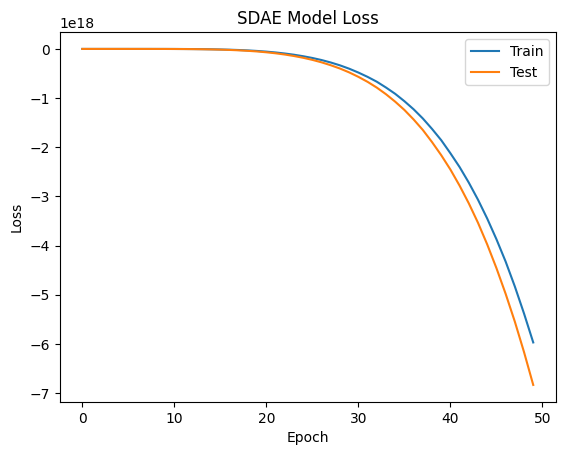

In [46]:
Result = fine_tuning(Train_SDAE, X, X_test, Y, y_test, layers = layers, epoch = 50, batch = 4, optimizer = 'adam', loss = 'binary_crossentropy')